In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import pandas as pd
import os
import shutil
import torch
import time
import matplotlib.pyplot as plt
%matplotlib inline
from torch import Tensor
from torch.nn import functional as F
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
import torchvision.transforms as tt
from torchvision import models
from torch.utils.data import DataLoader, ConcatDataset, Subset
from tempfile import TemporaryDirectory
from tqdm.notebook import tqdm
import numpy as np
from sklearn.metrics import classification_report, roc_auc_score, balanced_accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from torchsummary import summary

In [ ]:
# https://github.com/Bjarten/early-stopping-pytorch/blob/master/pytorchtools.py
class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        # torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def all_scores(labels, preds):
    report = classification_report(labels, preds, digits=3, output_dict=True, zero_division=0)
    acc_sc = balanced_accuracy_score(labels, preds)
    f1_sc = report['macro avg']['f1-score']
    recall_sc = report['macro avg']['recall']
    precision_sc = report['macro avg']['precision']
    return acc_sc, f1_sc, recall_sc, precision_sc

def softmax(x):
    return np.exp(x)/sum(np.exp(x))

def auc_roc_sc(labels, probs):
    pred_soft = [softmax(x) for x in probs]
    return roc_auc_score(labels, pred_soft, average='macro', multi_class='ovr')

In [ ]:
! unzip -q '/content/drive/MyDrive/msc_thesis/data/fer_ckplus.zip'
! unzip -q '/content/drive/MyDrive/msc_thesis/data/kdef.zip'
! unzip -q '/content/drive/MyDrive/msc_thesis/data/rafdb_test.zip'
! unzip -q '/content/drive/MyDrive/msc_thesis/data/rafdb_train.zip'

In [ ]:
valid_size = 490

data_transforms = {
    'train': tt.Compose([tt.Resize((64,64)),
                        tt.Grayscale(num_output_channels=1),
                        tt.RandomHorizontalFlip(),
                        tt.RandomRotation(30),
                        tt.ToTensor()]),
    'val': tt.Compose([tt.Resize((64,64)),
                        # tt.Grayscale(num_output_channels=1),
                        tt.ToTensor()]),
}

train_data = ImageFolder('/content/fer_ckplus', data_transforms['train'])
val_data = ImageFolder('/content/fer_ckplus', data_transforms['val'])

train_indices, val_indices, _, _ = train_test_split(
    range(len(train_data)),
    train_data.targets,
    stratify=train_data.targets,
    test_size=valid_size,
)

train_split = Subset(train_data, train_indices)
val_split = Subset(val_data, val_indices)
image_datasets = {
    'train': train_split,
    'val': val_split
    }

batch_size = 64
dataloaders = {x: DataLoader(image_datasets[x], batch_size=batch_size,
                                            shuffle=True, num_workers=2)
            for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
len(train_indices)

31744

In [ ]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        print(images[0].shape)
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break

In [ ]:
test_raf_ds = ImageFolder('/content/rafdb_test', data_transforms['val'])
test_raf_dl = DataLoader(test_raf_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)

torch.Size([1, 64, 64])


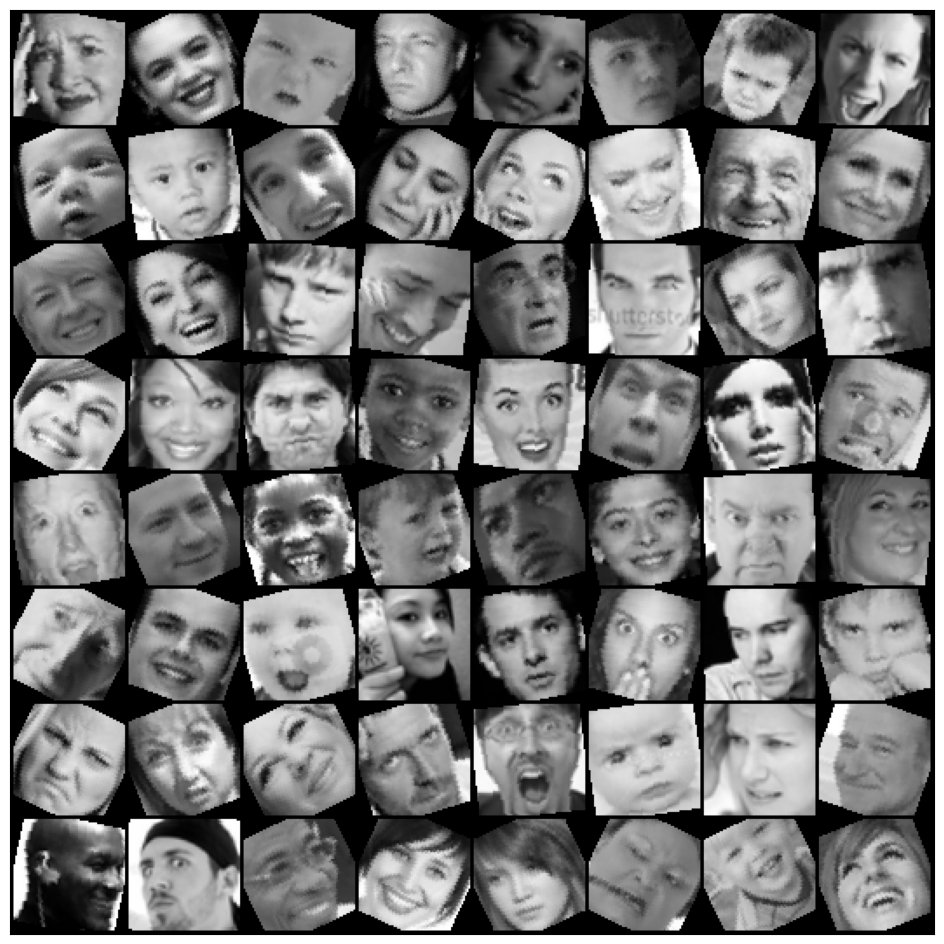

In [ ]:
show_batch(dataloaders['train'])

In [ ]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
              nn.BatchNorm2d(out_channels),
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()

        self.input = conv_block(in_channels, 64)

        self.conv1 = conv_block(64, 64, pool=True)
        self.res1 = nn.Sequential(conv_block(64, 32), conv_block(32, 64))
        self.drop1 = nn.Dropout(0.5)

        self.conv2 = conv_block(64, 64, pool=True)
        self.res2 = nn.Sequential(conv_block(64, 32), conv_block(32, 64))
        self.drop2 = nn.Dropout(0.5)

        self.conv3 = conv_block(64, 64, pool=True)
        self.res3 = nn.Sequential(conv_block(64, 32), conv_block(32, 64))
        self.drop3 = nn.Dropout(0.5)

        self.classifier = nn.Sequential(nn.MaxPool2d(6),
                                        nn.Flatten(),
                                        nn.Linear(64, num_classes))

    def forward(self, xb):
        out = self.input(xb)

        out = self.conv1(out)
        out = self.res1(out) + out
        out = self.drop1(out)

        out = self.conv2(out)
        out = self.res2(out) + out
        out = self.drop2(out)

        out = self.conv3(out)
        out = self.res3(out) + out
        out = self.drop3(out)

        return self.classifier(out)

In [ ]:
# source for training funtion https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#training-the-model
def train_model(model, criterion, optimizer, scheduler, grad_clip, num_epochs=20, patience=10):
    since = time.time()
    results = {'acc': [], 'f1': [], 'rec': [], 'prec': [], 'roc': [], 'val_loss': [], 'train_loss': [], 'lr': []}

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')
        early_stopping = EarlyStopping(patience=patience, verbose=False)
        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode
                    pred_list = []
                    label_list = []
                    output_list = []

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in tqdm(dataloaders[phase], leave=False, desc=phase):
                    if phase == 'val':
                        label_list = label_list + labels.tolist()

                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        if phase == 'val':
                            output_list = output_list + outputs.tolist()
                            pred_list = pred_list + preds.tolist()

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            if grad_clip:
                                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
                            optimizer.step()
                            scheduler.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                if phase == 'train':
                    train_loss = running_loss / dataset_sizes[phase]
                if phase == 'val':
                    val_loss = running_loss / dataset_sizes[phase]
                    acc, f1, prec, rec = all_scores(label_list, pred_list)
                    roc = auc_roc_sc(label_list, output_list)

                    results['acc'].append(acc)
                    results['f1'].append(f1)
                    results['prec'].append(prec)
                    results['rec'].append(rec)
                    results['roc'].append(roc)
                    results['val_loss'].append(val_loss)
                    results['train_loss'].append(train_loss)
                    results['lr'].append(get_lr(optimizer))

                    if epoch < 10:
                        s = '0'
                    else:
                        s = ''

                    print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
                        s+str(epoch), get_lr(optimizer), train_loss, val_loss, acc))

                # print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and acc > best_acc:
                    best_acc = acc
                    torch.save(model.state_dict(), best_model_params_path)

                    early_stopping(val_loss, model)

                    if early_stopping.early_stop:
                        print("Early stopping")
                        break

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model, results

In [ ]:
model = ResNet(1,7)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
max_lr = 0.001
epochs = 90
grad_clip = 0.2
weight_decay = 1e-4
optimizer = torch.optim.Adam(model.parameters(), max_lr, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(dataloaders['train']))

In [ ]:
summary(model, (1,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]             640
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
            Conv2d-4           [-1, 64, 64, 64]          36,928
       BatchNorm2d-5           [-1, 64, 64, 64]             128
              ReLU-6           [-1, 64, 64, 64]               0
         MaxPool2d-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 32, 32, 32]          18,464
       BatchNorm2d-9           [-1, 32, 32, 32]              64
             ReLU-10           [-1, 32, 32, 32]               0
           Conv2d-11           [-1, 64, 32, 32]          18,496
      BatchNorm2d-12           [-1, 64, 32, 32]             128
             ReLU-13           [-1, 64, 32, 32]               0
          Dropout-14           [-1, 64,

In [ ]:
model, results =  train_model(model, criterion, optimizer, scheduler, grad_clip, num_epochs=epochs, patience=4)

train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [00], last_lr: 0.00004, train_loss: 2.3942, val_loss: 1.8355, val_acc: 0.1429


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [01], last_lr: 0.00005, train_loss: 1.8404, val_loss: 1.8215, val_acc: 0.1429


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [02], last_lr: 0.00007, train_loss: 1.7952, val_loss: 1.8128, val_acc: 0.1418


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [03], last_lr: 0.00009, train_loss: 1.7603, val_loss: 1.7995, val_acc: 0.1441


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [04], last_lr: 0.00012, train_loss: 1.7089, val_loss: 1.7480, val_acc: 0.1879


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [05], last_lr: 0.00015, train_loss: 1.6543, val_loss: 1.6910, val_acc: 0.2649


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [06], last_lr: 0.00019, train_loss: 1.5659, val_loss: 1.5725, val_acc: 0.3190


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [07], last_lr: 0.00023, train_loss: 1.4738, val_loss: 1.4984, val_acc: 0.3475


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [08], last_lr: 0.00028, train_loss: 1.3940, val_loss: 1.3858, val_acc: 0.4115


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [09], last_lr: 0.00033, train_loss: 1.3352, val_loss: 1.3743, val_acc: 0.3874


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [10], last_lr: 0.00038, train_loss: 1.2817, val_loss: 1.4057, val_acc: 0.4089


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [11], last_lr: 0.00044, train_loss: 1.2411, val_loss: 1.2509, val_acc: 0.4547


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [12], last_lr: 0.00049, train_loss: 1.2024, val_loss: 1.1628, val_acc: 0.4671


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [13], last_lr: 0.00055, train_loss: 1.1652, val_loss: 1.1834, val_acc: 0.4699
EarlyStopping counter: 1 out of 4


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [14], last_lr: 0.00060, train_loss: 1.1456, val_loss: 1.1062, val_acc: 0.5569


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [15], last_lr: 0.00066, train_loss: 1.1181, val_loss: 1.1066, val_acc: 0.5278


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [16], last_lr: 0.00071, train_loss: 1.1014, val_loss: 1.1212, val_acc: 0.5749
EarlyStopping counter: 1 out of 4


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [17], last_lr: 0.00076, train_loss: 1.0715, val_loss: 1.0702, val_acc: 0.5418


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [18], last_lr: 0.00081, train_loss: 1.0606, val_loss: 1.1007, val_acc: 0.5564


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [19], last_lr: 0.00085, train_loss: 1.0389, val_loss: 1.0816, val_acc: 0.6011


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [20], last_lr: 0.00089, train_loss: 1.0269, val_loss: 1.0294, val_acc: 0.5524


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [21], last_lr: 0.00092, train_loss: 1.0192, val_loss: 1.1292, val_acc: 0.5964


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [22], last_lr: 0.00095, train_loss: 1.0039, val_loss: 1.0822, val_acc: 0.5504


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [23], last_lr: 0.00097, train_loss: 0.9936, val_loss: 1.0101, val_acc: 0.6248


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [24], last_lr: 0.00099, train_loss: 0.9820, val_loss: 0.9679, val_acc: 0.6381


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [25], last_lr: 0.00100, train_loss: 0.9695, val_loss: 1.0448, val_acc: 0.6291


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [26], last_lr: 0.00100, train_loss: 0.9604, val_loss: 0.9568, val_acc: 0.6162


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [27], last_lr: 0.00100, train_loss: 0.9459, val_loss: 0.9333, val_acc: 0.6507


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [28], last_lr: 0.00100, train_loss: 0.9403, val_loss: 0.9389, val_acc: 0.6476


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [29], last_lr: 0.00099, train_loss: 0.9330, val_loss: 1.0159, val_acc: 0.6301


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [30], last_lr: 0.00099, train_loss: 0.9262, val_loss: 0.9279, val_acc: 0.6761


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [31], last_lr: 0.00098, train_loss: 0.9174, val_loss: 0.9716, val_acc: 0.6304


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [32], last_lr: 0.00098, train_loss: 0.9065, val_loss: 0.9170, val_acc: 0.6469


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [33], last_lr: 0.00097, train_loss: 0.9061, val_loss: 0.9422, val_acc: 0.6337


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [34], last_lr: 0.00096, train_loss: 0.8953, val_loss: 0.9269, val_acc: 0.6451


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [35], last_lr: 0.00095, train_loss: 0.8848, val_loss: 0.9114, val_acc: 0.6500


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [36], last_lr: 0.00094, train_loss: 0.8781, val_loss: 0.9533, val_acc: 0.6640


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [37], last_lr: 0.00093, train_loss: 0.8737, val_loss: 0.8935, val_acc: 0.6307


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [38], last_lr: 0.00091, train_loss: 0.8728, val_loss: 0.8792, val_acc: 0.6900


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [39], last_lr: 0.00090, train_loss: 0.8627, val_loss: 0.9082, val_acc: 0.6382


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [40], last_lr: 0.00088, train_loss: 0.8613, val_loss: 0.8875, val_acc: 0.6503


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [41], last_lr: 0.00087, train_loss: 0.8504, val_loss: 0.9001, val_acc: 0.6465


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [42], last_lr: 0.00085, train_loss: 0.8483, val_loss: 0.9051, val_acc: 0.6535


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [43], last_lr: 0.00083, train_loss: 0.8453, val_loss: 0.8888, val_acc: 0.6723


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [44], last_lr: 0.00081, train_loss: 0.8339, val_loss: 0.8817, val_acc: 0.6551


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [45], last_lr: 0.00079, train_loss: 0.8319, val_loss: 0.8373, val_acc: 0.6883


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [46], last_lr: 0.00077, train_loss: 0.8299, val_loss: 0.8704, val_acc: 0.6657


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [47], last_lr: 0.00075, train_loss: 0.8212, val_loss: 0.8770, val_acc: 0.7056


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [48], last_lr: 0.00073, train_loss: 0.8207, val_loss: 0.8507, val_acc: 0.6785


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [49], last_lr: 0.00071, train_loss: 0.8126, val_loss: 0.8699, val_acc: 0.6675


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [50], last_lr: 0.00068, train_loss: 0.8046, val_loss: 0.8628, val_acc: 0.6729


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [51], last_lr: 0.00066, train_loss: 0.8016, val_loss: 0.8340, val_acc: 0.7055


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [52], last_lr: 0.00064, train_loss: 0.7978, val_loss: 0.8614, val_acc: 0.6748


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [53], last_lr: 0.00061, train_loss: 0.7966, val_loss: 0.8643, val_acc: 0.6782


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [54], last_lr: 0.00059, train_loss: 0.7920, val_loss: 0.8284, val_acc: 0.6864


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [55], last_lr: 0.00056, train_loss: 0.7828, val_loss: 0.8688, val_acc: 0.6815


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [56], last_lr: 0.00054, train_loss: 0.7769, val_loss: 0.8315, val_acc: 0.7120


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [57], last_lr: 0.00051, train_loss: 0.7752, val_loss: 0.8307, val_acc: 0.6758


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [58], last_lr: 0.00049, train_loss: 0.7682, val_loss: 0.8131, val_acc: 0.6989


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [59], last_lr: 0.00046, train_loss: 0.7685, val_loss: 0.8192, val_acc: 0.6959


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [60], last_lr: 0.00044, train_loss: 0.7688, val_loss: 0.8343, val_acc: 0.6902


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [61], last_lr: 0.00041, train_loss: 0.7549, val_loss: 0.8414, val_acc: 0.6631


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [62], last_lr: 0.00039, train_loss: 0.7508, val_loss: 0.8182, val_acc: 0.7001


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [63], last_lr: 0.00036, train_loss: 0.7460, val_loss: 0.8138, val_acc: 0.7067


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [64], last_lr: 0.00034, train_loss: 0.7438, val_loss: 0.7990, val_acc: 0.6933


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [65], last_lr: 0.00032, train_loss: 0.7391, val_loss: 0.8070, val_acc: 0.7058


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [66], last_lr: 0.00029, train_loss: 0.7336, val_loss: 0.7881, val_acc: 0.6918


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [67], last_lr: 0.00027, train_loss: 0.7318, val_loss: 0.7915, val_acc: 0.7002


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [68], last_lr: 0.00025, train_loss: 0.7292, val_loss: 0.7968, val_acc: 0.6891


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [69], last_lr: 0.00023, train_loss: 0.7220, val_loss: 0.7800, val_acc: 0.7036


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [70], last_lr: 0.00021, train_loss: 0.7201, val_loss: 0.7821, val_acc: 0.7016


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [71], last_lr: 0.00019, train_loss: 0.7157, val_loss: 0.7862, val_acc: 0.7189


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [72], last_lr: 0.00017, train_loss: 0.7109, val_loss: 0.7772, val_acc: 0.7206


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [73], last_lr: 0.00015, train_loss: 0.7040, val_loss: 0.7755, val_acc: 0.6990


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [74], last_lr: 0.00013, train_loss: 0.7061, val_loss: 0.7688, val_acc: 0.7243


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [75], last_lr: 0.00012, train_loss: 0.7001, val_loss: 0.7707, val_acc: 0.7260
EarlyStopping counter: 1 out of 4


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [76], last_lr: 0.00010, train_loss: 0.6944, val_loss: 0.7531, val_acc: 0.7266


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [77], last_lr: 0.00009, train_loss: 0.6990, val_loss: 0.7678, val_acc: 0.7252


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [78], last_lr: 0.00007, train_loss: 0.6924, val_loss: 0.7644, val_acc: 0.7189


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [79], last_lr: 0.00006, train_loss: 0.6917, val_loss: 0.7718, val_acc: 0.7083


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [80], last_lr: 0.00005, train_loss: 0.6882, val_loss: 0.7669, val_acc: 0.7119


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [81], last_lr: 0.00004, train_loss: 0.6881, val_loss: 0.7700, val_acc: 0.6955


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [82], last_lr: 0.00003, train_loss: 0.6855, val_loss: 0.7652, val_acc: 0.7176


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [83], last_lr: 0.00002, train_loss: 0.6839, val_loss: 0.7636, val_acc: 0.7012


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [84], last_lr: 0.00002, train_loss: 0.6806, val_loss: 0.7651, val_acc: 0.7066


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [85], last_lr: 0.00001, train_loss: 0.6812, val_loss: 0.7651, val_acc: 0.7001


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [86], last_lr: 0.00001, train_loss: 0.6807, val_loss: 0.7635, val_acc: 0.7084


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [87], last_lr: 0.00000, train_loss: 0.6842, val_loss: 0.7622, val_acc: 0.7001


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [88], last_lr: 0.00000, train_loss: 0.6789, val_loss: 0.7641, val_acc: 0.7057


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [89], last_lr: 0.00000, train_loss: 0.6795, val_loss: 0.7632, val_acc: 0.7069
Training complete in 65m 51s
Best val Acc: 0.726644


In [ ]:
kdef_ds = ImageFolder('/content/kdef', data_transforms['val'])
kdef_test_dl = DataLoader(kdef_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)

model.eval()
label_list = []
output_list = []
pred_list = []
for inputs, labels in tqdm(kdef_test_dl, leave=False, desc='Test'):
    label_list = label_list + labels.tolist()

    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.set_grad_enabled(False):
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        output_list = output_list + outputs.tolist()
        pred_list = pred_list + preds.tolist()
acc, f1, prec, rec = all_scores(label_list, pred_list)
roc = auc_roc_sc(label_list, output_list)

print('acc:', round(acc, 4), ', roc:', round(roc, 4), ', f1:', round(f1, 4), ', recall:', round(rec, 4))

Test:   0%|          | 0/8 [00:00<?, ?it/s]

acc: 0.6122 , roc: 0.9415 , f1: 0.5864 , recall: 0.7317


In [ ]:
test_raf_ds = ImageFolder('/content/rafdb_test', data_transforms['val'])
test_raf_dl = DataLoader(test_raf_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)

model.eval()
label_list = []
output_list = []
pred_list = []
for inputs, labels in tqdm(test_raf_dl, leave=False, desc='Test'):
    label_list = label_list + labels.tolist()

    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.set_grad_enabled(False):
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        output_list = output_list + outputs.tolist()
        pred_list = pred_list + preds.tolist()
acc, f1, prec, rec = all_scores(label_list, pred_list)
roc = auc_roc_sc(label_list, output_list)

print('acc:', round(acc, 4), ', roc:', round(roc, 4), ', f1:', round(f1, 4), ', recall:', round(rec, 4))

Test:   0%|          | 0/48 [00:00<?, ?it/s]

acc: 0.4804 , roc: 0.8842 , f1: 0.437 , recall: 0.5602


In [ ]:
# acc: 0.663265306122449 , roc: 0.9513459669582119 , f1: 0.6452388586723082 (ep: 60 lr: 0.001 gc 0.1)

In [ ]:
# acc: 0.6918367346938775 , roc: 0.9473372206025267 , f1: 0.6508315059070727 (ep: 40 lr: 0,001 gc 0.2)

In [ ]:
# acc: 0.710204081632653 , roc: 0.9571817298347911 , f1: 0.6888354804934647 (ep: 40 lr: 0,001 gc 0.2)

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/msc_thesis/notebooks/resnetnew.pt')

In [ ]:
print(results)

{'acc': [0.14285714285714285, 0.14285714285714285, 0.14181438998957246, 0.1440819636857176, 0.18785594369195863, 0.26493181608641947, 0.31904490556685455, 0.347524430731336, 0.4115058192655078, 0.3873890312176383, 0.4089490076363158, 0.4546544310822317, 0.46707272789056326, 0.4698518250246652, 0.5569012199503531, 0.5277871245249642, 0.5749382625826217, 0.5417999598175264, 0.5563621967692592, 0.6010992130169398, 0.5523683115317416, 0.5963557972633472, 0.5504231625281442, 0.624827619888806, 0.6381300205234258, 0.6290836419729595, 0.6161964494567057, 0.6507399048252782, 0.6476010537890726, 0.6300734963646725, 0.6761467502198754, 0.6304448735508583, 0.6469264800198706, 0.6337305664685807, 0.6450707754548477, 0.6499924323470081, 0.66400463208124, 0.6306716114014516, 0.6900066248635612, 0.6381525380444092, 0.6503321365130124, 0.6464710013134524, 0.653542360369699, 0.6722569106479584, 0.6550918055971783, 0.6883241750048104, 0.6656547313001536, 0.7055956054767495, 0.678514778827873, 0.66753513

In [ ]:
results = {'acc': [0.14285714285714285, 0.14285714285714285, 0.14181438998957246, 0.1440819636857176, 0.18785594369195863, 0.26493181608641947, 0.31904490556685455, 0.347524430731336, 0.4115058192655078, 0.3873890312176383, 0.4089490076363158, 0.4546544310822317, 0.46707272789056326, 0.4698518250246652, 0.5569012199503531, 0.5277871245249642, 0.5749382625826217, 0.5417999598175264, 0.5563621967692592, 0.6010992130169398, 0.5523683115317416, 0.5963557972633472, 0.5504231625281442, 0.624827619888806, 0.6381300205234258, 0.6290836419729595, 0.6161964494567057, 0.6507399048252782, 0.6476010537890726, 0.6300734963646725, 0.6761467502198754, 0.6304448735508583, 0.6469264800198706, 0.6337305664685807, 0.6450707754548477, 0.6499924323470081, 0.66400463208124, 0.6306716114014516, 0.6900066248635612, 0.6381525380444092, 0.6503321365130124, 0.6464710013134524, 0.653542360369699, 0.6722569106479584, 0.6550918055971783, 0.6883241750048104, 0.6656547313001536, 0.7055956054767495, 0.678514778827873, 0.6675351302976037, 0.6728806913933287, 0.7054674995701227, 0.6748111230355878, 0.6782118568336125, 0.686392827897199, 0.6815308668120037, 0.7120153400120798, 0.6758251554958093, 0.6989035914211222, 0.6959398062305799, 0.6902448469195602, 0.6630945716455816, 0.7001307703539973, 0.7067404962942411, 0.6932755825261196, 0.7057761401039587, 0.6917911150333851, 0.7002252104999388, 0.689137905862894, 0.7035929914273549, 0.7015801858866977, 0.7188735528635914, 0.7205523122684168, 0.6989991631730982, 0.7243050477133932, 0.7260358691153657, 0.7266439594024836, 0.7252153092899628, 0.7188943624702157, 0.7083058069414542, 0.7119145311840082, 0.6955328615059698, 0.7176068547327598, 0.7011514447710306, 0.7066266133306282, 0.7000550528672324, 0.7083902817609632, 0.7000550528672324, 0.705705192130569, 0.7068750173349007], 'f1': [0.06262857142857144, 0.06252852578731173, 0.062171428571428565, 0.06663571428571428, 0.1345951657581247, 0.21449579831932772, 0.2874874975024882, 0.33438723091163886, 0.39770407359643933, 0.3633360332455788, 0.3796744711472716, 0.4314196271944671, 0.4589118037594316, 0.4385328963758484, 0.5628290869095075, 0.5286425015385451, 0.5878980623945683, 0.5455660276892906, 0.5493223503355759, 0.5754136425288285, 0.5484499958680416, 0.5679077950132465, 0.5591481941575741, 0.6316658036062844, 0.6461274217792301, 0.6299491230248906, 0.6179704339335385, 0.6438022755382556, 0.6406188658312326, 0.639203523321351, 0.6706371820038406, 0.6184092530455868, 0.6466370125603825, 0.649373112700036, 0.6601902692336434, 0.655077030637515, 0.6707231646820312, 0.6519805236771107, 0.6987787415890683, 0.6545443235236268, 0.6676009255556832, 0.6297793662919713, 0.6642503675774619, 0.6812493008354998, 0.6713639208560233, 0.69802138246603, 0.6817598589792454, 0.7022946665985695, 0.700585790097554, 0.6891116418247865, 0.6843687435584288, 0.7075330725940567, 0.6943936976450973, 0.6692089748571041, 0.699116041979771, 0.6868927685755682, 0.7182603542623748, 0.6810425301363864, 0.6968957002428892, 0.7139193987004689, 0.697371276017341, 0.6827414315954223, 0.692969758329054, 0.7096804203735604, 0.7037270620238311, 0.7083451207791123, 0.6941208958615525, 0.6923492803933194, 0.6902916307687244, 0.7066230254055484, 0.7069910859527255, 0.7100709511738845, 0.7190431818085887, 0.6995662933360386, 0.7298850242827261, 0.7226888069582612, 0.7243621443428665, 0.7224353854191763, 0.7243600330416621, 0.7109931624263153, 0.7113063077352361, 0.6923396255620011, 0.7171418386429489, 0.7041631186160114, 0.710407650965747, 0.7032253470665458, 0.7124315642415333, 0.702923720345317, 0.7088547129852227, 0.7104914802892444], 'rec': [0.04010538641686183, 0.040023371311714864, 0.039812646370023415, 0.18266978922716628, 0.17263182409222352, 0.2244571547965602, 0.2838789535703329, 0.3460048902258851, 0.39287188683730573, 0.36065622364291405, 0.44236244783915907, 0.41957222527397137, 0.46673408101979535, 0.4380008531693237, 0.6032164838649061, 0.6231318366148371, 0.637087704798548, 0.6104379911672694, 0.5805251191205593, 0.5778617114136002, 0.614801373271212, 0.5828972175878021, 0.6621621439991866, 0.6720512218132022, 0.6664666105480912, 0.6531118605170672, 0.6527600872112016, 0.6655372867192171, 0.6452333419417161, 0.666949247173858, 0.6848564693717603, 0.6212480572111844, 0.6868091770831496, 0.7109091508971367, 0.7117801447433204, 0.6690957243365633, 0.6837665638620527, 0.7034436974169705, 0.7175236580139303, 0.6955359083170727, 0.69869927178413, 0.6287938355640218, 0.6942288929176328, 0.7296666387431404, 0.7044670305539871, 0.7437187308785947, 0.7397907793545321, 0.7145991902476568, 0.7384287249052649, 0.7295526930334084, 0.7055175817094199, 0.722961112520807, 0.7308597477600632, 0.6678083039634038, 0.7279496470389777, 0.7001311683245616, 0.7283738107414653, 0.6983437669453082, 0.6975518702104498, 0.7518908944851938, 0.7277531788598811, 0.7318092020245919, 0.6923461330039691, 0.7239870700986403, 0.72999432901451, 0.7193084415798982, 0.7049185769029666, 0.6894581046202536, 0.7064811821453656, 0.7234309169735972, 0.7300409241884932, 0.7084801138091631, 0.7315049193050802, 0.7149904343736436, 0.7415421598726246, 0.727482833549743, 0.7314777426350715, 0.7231651751749988, 0.7353405070626206, 0.7188276592688357, 0.7184823942889761, 0.6959916636139456, 0.7211153732391747, 0.7134975283717064, 0.7198260918702974, 0.7129871535138399, 0.7217561800646379, 0.7113722278157917, 0.7171351158267444, 0.7197565185864384], 'prec': [0.14285714285714285, 0.14285714285714285, 0.14181438998957246, 0.1440819636857176, 0.18785594369195863, 0.26493181608641947, 0.31904490556685455, 0.347524430731336, 0.4115058192655078, 0.3873890312176383, 0.4089490076363158, 0.4546544310822317, 0.46707272789056326, 0.4698518250246652, 0.5569012199503531, 0.5277871245249642, 0.5749382625826217, 0.5417999598175264, 0.5563621967692592, 0.6010992130169398, 0.5523683115317416, 0.5963557972633472, 0.5504231625281442, 0.624827619888806, 0.6381300205234258, 0.6290836419729595, 0.6161964494567057, 0.6507399048252782, 0.6476010537890726, 0.6300734963646725, 0.6761467502198754, 0.6304448735508583, 0.6469264800198706, 0.6337305664685807, 0.6450707754548477, 0.6499924323470081, 0.66400463208124, 0.6306716114014516, 0.6900066248635612, 0.6381525380444092, 0.6503321365130124, 0.6464710013134524, 0.653542360369699, 0.6722569106479584, 0.6550918055971783, 0.6883241750048104, 0.6656547313001536, 0.7055956054767495, 0.678514778827873, 0.6675351302976037, 0.6728806913933287, 0.7054674995701227, 0.6748111230355878, 0.6782118568336125, 0.686392827897199, 0.6815308668120037, 0.7120153400120798, 0.6758251554958093, 0.6989035914211222, 0.6959398062305799, 0.6902448469195602, 0.6630945716455816, 0.7001307703539973, 0.7067404962942411, 0.6932755825261196, 0.7057761401039587, 0.6917911150333851, 0.7002252104999388, 0.689137905862894, 0.7035929914273549, 0.7015801858866977, 0.7188735528635914, 0.7205523122684168, 0.6989991631730982, 0.7243050477133932, 0.7260358691153657, 0.7266439594024836, 0.7252153092899628, 0.7188943624702157, 0.7083058069414542, 0.7119145311840082, 0.6955328615059698, 0.7176068547327598, 0.7011514447710306, 0.7066266133306282, 0.7000550528672324, 0.7083902817609632, 0.7000550528672324, 0.705705192130569, 0.7068750173349007], 'roc': [0.5613161724572826, 0.5893694305017636, 0.6270598131996962, 0.6347306600839485, 0.6890600007505444, 0.7121494638458177, 0.770974270052163, 0.8047274963955445, 0.8433078856327599, 0.8533213448097602, 0.8532322124151653, 0.8773552892351185, 0.8869418314761504, 0.8876326556440322, 0.9025970239362169, 0.9011803314108772, 0.904578753408173, 0.903849026231985, 0.9092024360378719, 0.9112499315563115, 0.9196189388154313, 0.913255276540129, 0.9126375843473106, 0.9236506111915987, 0.9263996415810245, 0.9181128464573279, 0.9277733404864953, 0.9285959295209293, 0.9286398320195416, 0.9201983068241617, 0.9301906257065973, 0.9296400746507487, 0.9292837601051801, 0.9325494331462378, 0.9338673614359394, 0.9305317722447536, 0.9303394488533029, 0.9306363936129772, 0.9360046791940134, 0.9356002944454269, 0.9382231807315067, 0.9386918159162219, 0.9353827604667073, 0.937014908029801, 0.9383326983364908, 0.9456500399731173, 0.9385719039855898, 0.9408979982963104, 0.9406699199746386, 0.9389504164839823, 0.939319578195702, 0.9457686183713988, 0.9430317038858282, 0.9374029569723499, 0.9453888025643673, 0.9422067096683542, 0.944955725166685, 0.9434333023844166, 0.9450294829930531, 0.9446022763800874, 0.9420576298325002, 0.9433034470296316, 0.9443432751994921, 0.9453863939141067, 0.944969511512749, 0.948276662642006, 0.9477849556712751, 0.9473290235892924, 0.9480002524041252, 0.9502736635930459, 0.9483234209212943, 0.9489821122967897, 0.9501678809186094, 0.9498011725016446, 0.9517172363956388, 0.9510406118108538, 0.9520531737640997, 0.9506999672854012, 0.9506795756286717, 0.9499837241091026, 0.9505068601943348, 0.9503008850871071, 0.9505776007994753, 0.9506004021266486, 0.9509648716029316, 0.9506187728013684, 0.9507855014320393, 0.9508740410292023, 0.9508547917436162, 0.9507506723804352], 'val_loss': [1.8355062168471667, 1.8214675436214525, 1.8127707656548948, 1.799488801858863, 1.7480447764299354, 1.6909911501164339, 1.572509148169537, 1.498413449404191, 1.3858057343229955, 1.3743279403569748, 1.4056790230225544, 1.250915508854146, 1.16275310662328, 1.1833869608081118, 1.1061903554566053, 1.1066087562210707, 1.1212478983158969, 1.0702039772150467, 1.1006858820817909, 1.081571497722548, 1.029443004179974, 1.1292443693900596, 1.0822059752989788, 1.0101295699878614, 0.967859034878867, 1.044779525970926, 0.9567665652352937, 0.9333071205080772, 0.9389408714917241, 1.0158554476134631, 0.9278986575652142, 0.9716169196732191, 0.916975957520154, 0.9421950481375869, 0.9269158548238327, 0.9114276669463333, 0.9533128514581797, 0.8935014985045608, 0.8791832184304996, 0.9082176889692034, 0.8874807953834534, 0.9000543008045274, 0.9050657844056889, 0.8887797937101247, 0.8816553271546655, 0.8372613028604157, 0.8703903952423407, 0.8770398495148639, 0.8507063654004311, 0.8698775836399624, 0.8628243640977509, 0.8340240030872579, 0.8614131993176986, 0.864335758588752, 0.8284085850326383, 0.8688497280587956, 0.8315449018867649, 0.8307267702355676, 0.8130512322698321, 0.8192331727670163, 0.8343057286982634, 0.8414030104267354, 0.8181591902460371, 0.8138025028364999, 0.7989679443592927, 0.8069604272745093, 0.7881461846585176, 0.7915297992375432, 0.7968191324448098, 0.7799799559067707, 0.7820793730872018, 0.7861853993668848, 0.7772445941457943, 0.7754747067178999, 0.7687558125476448, 0.770679029396602, 0.753117213443834, 0.7678097464600387, 0.7644284912518092, 0.7718130002216417, 0.7668673945932972, 0.7699600942280828, 0.7652130740029471, 0.7635874332213889, 0.765077610405124, 0.7650742737614379, 0.763484765802111, 0.7621930747616048, 0.764109989331693, 0.7631534554520432], 'train_loss': [2.394240217583795, 1.8403906754909023, 1.7951784951071585, 1.7602939358161342, 1.708921031846154, 1.654266751821964, 1.565927520153984, 1.4737586864540655, 1.3940199474173207, 1.335228180693042, 1.2816691942993672, 1.2410569037160566, 1.2023556415111787, 1.1652355879064529, 1.1456158878582139, 1.1180916545131514, 1.1014090301769395, 1.0714868599128338, 1.0605707830719409, 1.038864606570813, 1.0268657265170928, 1.0191521815234614, 1.0039276790715033, 0.9935960170001753, 0.981967433325706, 0.96950684547905, 0.9604001664105923, 0.9458976891492644, 0.9403303236730637, 0.9330085217952728, 0.9262350971900648, 0.9173741599004115, 0.9065159316505155, 0.9061219898923751, 0.895327560483448, 0.8848098291745109, 0.8780766451551069, 0.8736975029591592, 0.8728090189397335, 0.8627206367110053, 0.8612635700452712, 0.8503830367999692, 0.8483029791424351, 0.8452716127278344, 0.833920179716041, 0.8319167563271138, 0.8298645660641694, 0.8211536811244103, 0.8206554978124557, 0.8125832468992279, 0.8046390939984591, 0.8015964490271383, 0.7977883016029673, 0.7966067878709685, 0.7919828354591324, 0.7828492160526014, 0.7768796286996333, 0.7751765894673525, 0.7681716112119537, 0.7685398381323584, 0.7687705422961905, 0.7548958614108062, 0.7507562872863585, 0.7459721001646211, 0.7438255559893385, 0.7390724361663864, 0.733588763963311, 0.7318000735174264, 0.7291880232552367, 0.7219581427953897, 0.7201265624213603, 0.7156938611259384, 0.7109041174933795, 0.703970558160255, 0.706136737439421, 0.7001252749994877, 0.6943722818527491, 0.6990340367680595, 0.6924495197712414, 0.6916640369642165, 0.6881931250494334, 0.6881300346144745, 0.6855377308543651, 0.6838997731646222, 0.6806157988405996, 0.6812034373081499, 0.680706407754652, 0.6841605702234853, 0.6788571904743871, 0.6794804962532174], 'lr': [4.324607249658419e-05, 5.2940385875282266e-05, 6.895182161929477e-05, 9.106382022362389e-05, 0.00011897731022779455, 0.00015231475324769758, 0.00019062525029627745, 0.00023339064032853454, 0.00028003250852617987, 0.00032992000953277294, 0.00038237839982772687, 0.00043669816383624395, 0.0004921446103417866, 0.000547967809406709, 0.0006034127354011946, 0.0006577294789529692, 0.000710183389698085, 0.0007600650126490086, 0.0008066996837876319, 0.0008494566550999119, 0.00088775762563329, 0.0009210845631917625, 0.0009489867108778133, 0.0009710866837156114, 0.0009870855728968072, 0.0009967669886124545, 0.000999999997473068, 0.0009993759548939996, 0.0009975103899806281, 0.0009944079408212706, 0.0009900763205933658, 0.0009845262983872998, 0.00097777167243275, 0.0009698292357941133, 0.0009607187346203005, 0.0009504628190526999, 0.0009390869869133568, 0.0009266195203133702, 0.0009130914153391087, 0.0008985363049910555, 0.0008829903755668704, 0.0008664922766965522, 0.0008490830252533688, 0.0008308059033794464, 0.000811706350879547, 0.0007918318522505517, 0.000771231818627521, 0.0007499574649398274, 0.0007280616825827717, 0.00070559890792124, 0.0006826249869523242, 0.0006591970364633736, 0.0006353733020306619, 0.000611213013211708, 0.0005867762362912628, 0.0005621237249470618, 0.0005373167692066096, 0.0005124170430705143, 0.0004874864511812046, 0.00046258697491823535, 0.00043778051830281145, 0.00041312875409463745, 0.00038869297046371996, 0.0003645339186183204, 0.00034071166176787845, 0.00031728542579641077, 0.0002943134520176302, 0.00027185285237786485, 0.00024995946746675943, 0.00022868772768877216, 0.00020809051794061197, 0.0001882190461310538, 0.00016912271587000784, 0.00015084900364336238, 0.00013344334077895797, 0.00011694900049714957, 0.00010140699032676132, 8.685595015390971e-05, 7.333205615715733e-05, 6.086893086783435e-05, 4.9497559579126644e-05, 3.924621331175594e-05, 3.0140378527766904e-05, 2.220269376716765e-05, 1.5452893364951626e-05, 9.907758388431883e-06, 5.581074916863558e-06, 2.48359976707845e-06, 6.230337503438279e-07, 4.002526932047755e-09]}


In [ ]:
criterion = nn.CrossEntropyLoss()
model = ResNet(1,7)
model.load_state_dict(torch.load('/content/drive/MyDrive/msc_thesis/notebooks/resnetnew.pt'))
model = model.to(device)

In [ ]:
! unzip -q '/content/drive/MyDrive/msc_thesis/data/kdef_faces.zip'
criterion = nn.CrossEntropyLoss()
kdef_f_ds = ImageFolder('/content/kdef_faces', data_transforms['val'])
kdef_f_test_dl = DataLoader(kdef_f_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)

model.eval()
label_list = []
output_list = []
pred_list = []
for inputs, labels in tqdm(kdef_f_test_dl, leave=False, desc='Test'):
    label_list = label_list + labels.tolist()

    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.set_grad_enabled(False):
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        output_list = output_list + outputs.tolist()
        pred_list = pred_list + preds.tolist()
acc, f1, prec, rec = all_scores(label_list, pred_list)
roc = auc_roc_sc(label_list, output_list)

print('acc:', round(acc, 4), ', roc:', round(roc, 4), ', f1:', round(f1, 4), ', recall:', round(rec, 4))

Test:   0%|          | 0/8 [00:00<?, ?it/s]

acc: 0.698 , roc: 0.9572 , f1: 0.6772 , recall: 0.7662


In [ ]:
def plot_scores(results):
    plt.figure(figsize=(8, 6), dpi=150)
    epochs = len(results['acc'])
    # plt.plot(results['prec'], color='limegreen', label='precision')
    plt.plot(results['rec'], color='orange', label='recall')
    plt.plot(results['f1'], color='dodgerblue', label='f1-score')
    plt.plot(results['roc'], color = 'blueviolet', label='roc-auc')
    plt.plot(results['acc'], color='red', label='accuracy')
    plt.ylabel('performance scores')
    plt.ylim([0,1])
    plt.legend(loc='lower right')
    plt.xlabel('epoch')
    plt.title('Model performance vs. No. of epochs')
    plt.show()

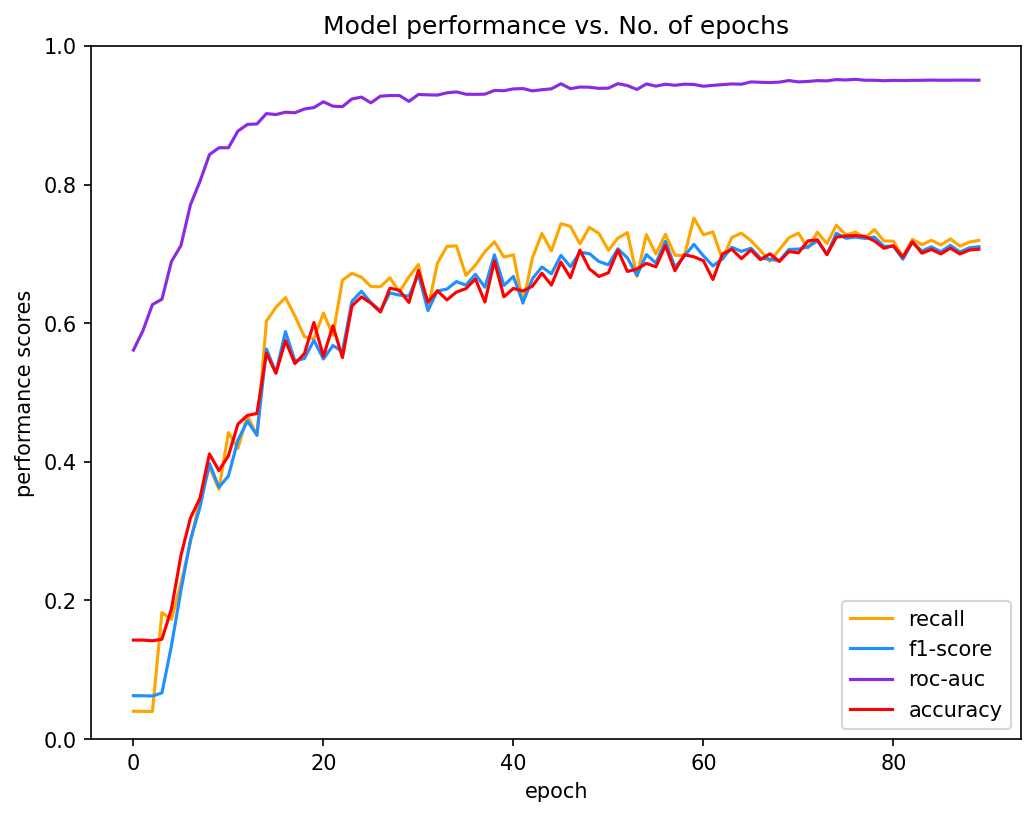

In [ ]:
plot_scores(results)

In [ ]:
def plot_lrs(lrs):
    plt.figure(figsize=(8, 6), dpi=150)
    plt.plot(lrs)
    plt.xlabel('Epoch')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Epoch for training without RAF-DB')
    plt.xlim(-5,95)

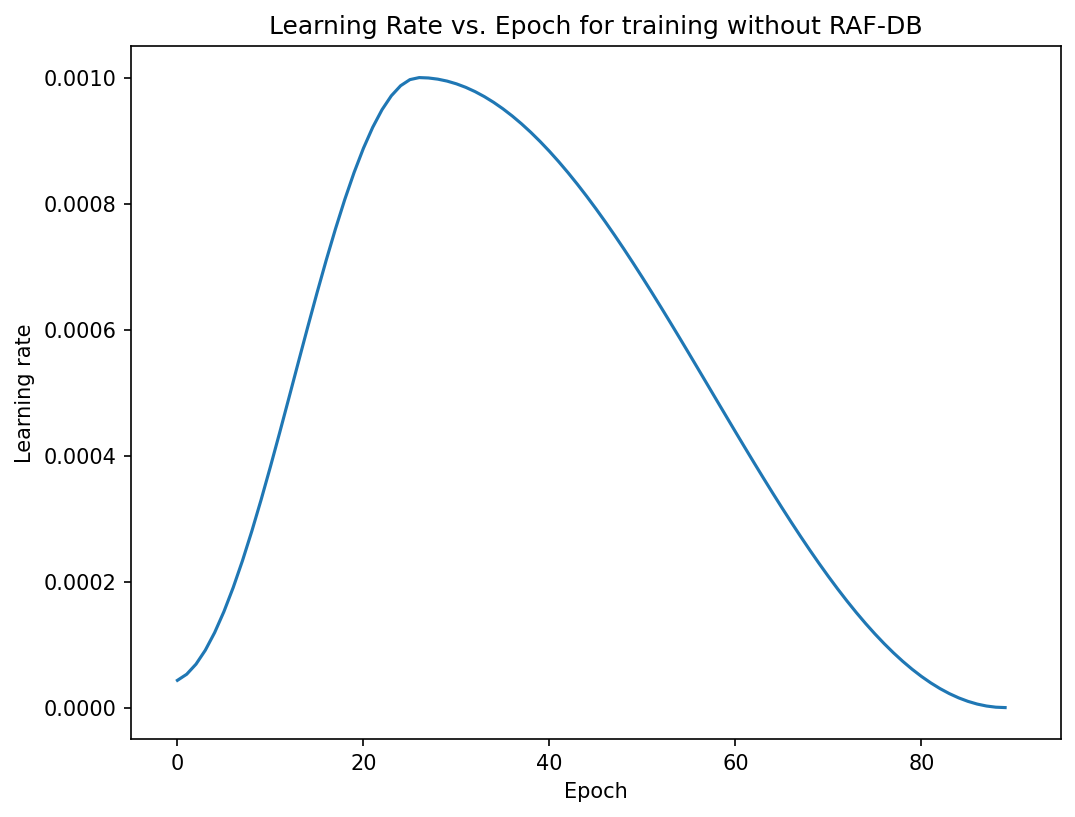

In [ ]:
plot_lrs(results['lr'])